In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.simplefilter("ignore")

In [112]:
class CurrencyAnalysis:
    def __init__(self,alpha,df_name,col,date_min,date_max,date_test,currency_name):        
        self.alpha=alpha
        self.df_name=df_name
        self.col=col
        self.currency_name=currency_name
        self.model=None
        self.results=None
        self.date_min=date_min
        self.date_max=date_max
        self.date_test=date_test
        self.df=self.read_df()
        
    @staticmethod
    def init_figure():
        plt.gcf().set_size_inches(6,3.5)
    
    def _read_df(self,index='Date'):
        df1=pd.read_csv(self.df_name)
        df1[index]=df1[index].apply(pd.to_datetime)
        df1=df1[(df1[index]>=date_min) & (df1[index]<=date_max)]
        df1=df1.set_index(index)
        df1[self.col]=df1[self.col].astype(float)
        return df1
    
    def read_df(self,index='Date'):
        try:
            return self._read_df(index)
        except:
            return self.parse_data2([self.col])
        
    def parse_data2(self,cols):
        fname=self.df_name
        df=pd.read_excel(fname)
        df=df.iloc[1:237]
        df['Date']=df['data'].apply(pd.to_datetime)
        for x in cols:
            df[x]=df[x].astype(float)
        df['Open']=df[cols[0]]
        df.set_index('Open')
        df=df[(df['Date']>=self.date_min) & (df['Date']<=self.date_max)]
        return df
    
    def _test(self,col='Open',index='Date'):
        df_test=pd.read_csv(self.df_name)
        df_test[index]=df_test[index].apply(pd.to_datetime)
        df_test=df_test[(df_test[index]>=self.date_max) & (df_test[index]<=self.date_test)]
        df_test=df_test.set_index(index)
        df_test=df_test[self.col].astype(float)
        return df_test
    
    def test(self,col='Open',index='Date'):
        try:
            return self._test(index)
        except:
            fname=self.df_name
            df=pd.read_excel(fname)
            df=df.iloc[1:237]
            df['Date']=df['data'].apply(pd.to_datetime)
            df[self.col]=df[self.col].astype(float)
            df['Open']=df[self.col]
            df.set_index('Date')
            df=df[(df['Date']>=self.date_max) & (df['Date']<=self.date_test)]
            return df['Open']
        
    
    def adf_test(self,df=None,col='Open'):
        if df is None:
            df=self.df[col]
        result = adfuller(df)
        print(col)
        print('ADF Statistic: {}'.format(result[0]))
        print('p-value: {}'.format(result[1]))
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t{}: {}'.format(key, value))
    
    @staticmethod
    def get_stationarity(timeseries,title=''):
        # rolling statistics
        rolling_mean = timeseries.rolling(window=12).mean()
        rolling_std = timeseries.rolling(window=12).std()
        # rolling statistics plot
        original = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
        std = plt.plot(rolling_std, color='black', label='Rolling Std')
        plt.legend(loc='best',prop={'size': 6})
        plt.title('Rolling Mean & Standard Deviation: '+title)
        plt.show(block=False)

        
    def stationarity(self,adf_test=True):
        self.init_figure()
        self.get_stationarity(self.df[self.col],self.currency_name)
        # Dickey–Fuller test:
        if adf_test:
            self.adf_test()
        
    def df_log_minus_mean(self,plot=True):
        df_log = self.df[self.col]
        rolling_mean = df_log.rolling(window=12).mean()
        df_log_minus_mean = df_log - rolling_mean
        df_log_minus_mean.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_minus_mean,self.currency_name)
            self.adf_test(df_log_minus_mean)
        return df_log_minus_mean
    
    def df_log_exp_decay(self,half_life,plot=True):
        df_log=self.df[self.col]
        rolling_mean_exp_decay = df_log.ewm(halflife=half_life, min_periods=0, adjust=True).mean()
        df_log_exp_decay = df_log - rolling_mean_exp_decay
        df_log_exp_decay.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_exp_decay,self.currency_name)
            self.adf_test(df_log_exp_decay)
        return df_log_exp_decay
    
    def df_log_shift(self,plot=True):
        df_log = self.df[self.col]
        df_log_shift = df_log - df_log.shift()
        df_log_shift.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_shift,self.currency_name)
            self.adf_test(df_log_shift)
        return df_log_shift
    
    def arima_build(self,p,d,q,plot=True):
        plt.gcf().set_size_inches(4,2.5)
        plt.gca().axes.get_xaxis().set_visible(False)
        df_log=self.df[self.col]
        #decomposition = seasonal_decompose(df_log) 
        self.model = ARIMA(df_log, order=(p,d,q))
        self.results = self.model.fit()
        if plot:
            plt.plot(self.df_log_shift(plot=False))
            plt.plot(self.results.fittedvalues, color='red')
    
    def arima_predict(self,n=264):
        results=self.results
        df_log=self.df[self.col]
        predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
        predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
        predictions_ARIMA = np.exp(predictions_ARIMA_log)
        #self.init_figure()
        plt.plot(results.predict(1,n),label='Predicted')
        plt.plot(self.test('Open'),label='Actual')
        #plt.show()
        

In [113]:
alp=0.05
col='Open'

date_min=pd.to_datetime("2020.01.01")
date_max=pd.to_datetime("2020.08.01")
date_test=pd.to_datetime("2021")
df_doge="coin_Dogecoin.csv"
df_btc="coin_Bitcoin.csv"
df_currencies="currencies.xls"
btc=CurrencyAnalysis(alp,df_btc,col,date_min,date_max,date_test,'BTC')

In [114]:
btc.df['Open']

Date
2020-01-01 23:59:59     7194.891971
2020-01-02 23:59:59     7202.551122
2020-01-03 23:59:59     6984.428612
2020-01-04 23:59:59     7345.375275
2020-01-05 23:59:59     7410.451694
                           ...     
2020-07-27 23:59:59     9905.217914
2020-07-28 23:59:59    11017.463848
2020-07-29 23:59:59    10912.952961
2020-07-30 23:59:59    11099.832891
2020-07-31 23:59:59    11110.210942
Name: Open, Length: 213, dtype: float64

In [115]:

date_min=pd.to_datetime("2021.01.01")
date_max=pd.to_datetime("2022.08.01")
date_test=pd.to_datetime("2022.12.01")

thb=CurrencyAnalysis(alp,df_currencies,'1 THB',date_min,date_max,date_test,'THB')

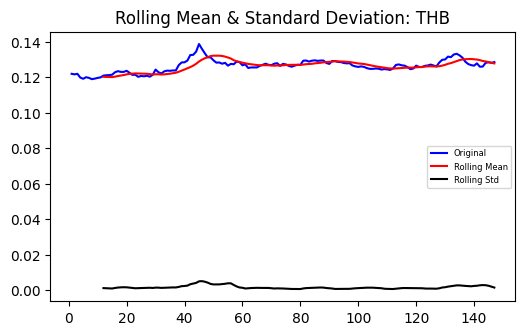

Open
ADF Statistic: -2.9605595750553624
p-value: 0.0387454263530986
Critical Values:
	1%: -3.4769274060112707
	5%: -2.8819726324025625
	10%: -2.577665408088415


In [116]:
thb.stationarity()

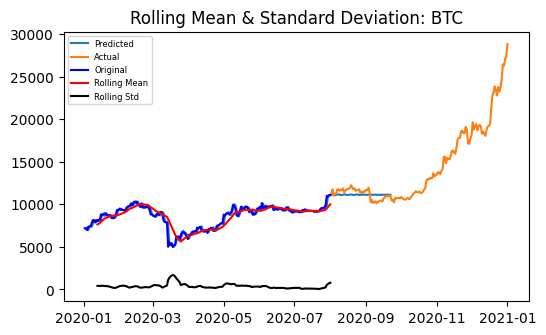

In [117]:
btc.arima_build(3,1,6)
plt.clf()

btc.arima_predict(264)
btc.stationarity(adf_test=False)

p-value > 0.05 => we conclude that the stationarity isn't present in the sample

Transform data:
(options)
1. subtract rolling mean
2. exponential decay
3. shift values & subtract
4. .

In [8]:
"""
def parse_data2(cols):
    fname="currencies.xls"
    df=pd.read_excel(fname)
    df=df.iloc[1:237]
    df['data']=df['data'].apply(pd.to_datetime)
    df.set_index('data')
    for x in cols:
        df[x]=df[x].astype(float)
    return df
"""
pass

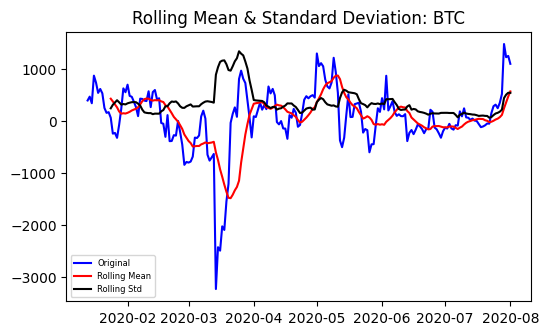

Open
ADF Statistic: -4.105170908052709
p-value: 0.00094963801216218
Critical Values:
	1%: -3.463987334463603
	5%: -2.8763259091636213
	10%: -2.5746515171738515


In [9]:
btc.df_log_minus_mean()
plt.show()

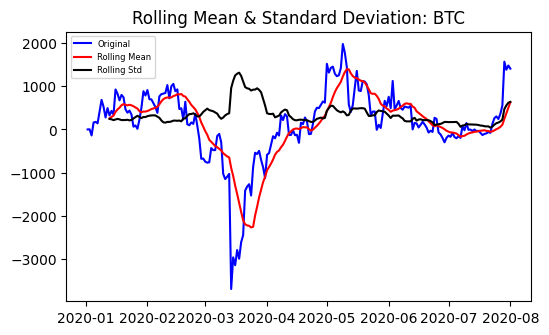

Open
ADF Statistic: -2.217157523091184
p-value: 0.20007730155239345
Critical Values:
	1%: -3.46172743446274
	5%: -2.8753374677799957
	10%: -2.574124089081557


In [10]:
btc.df_log_exp_decay(half_life=12)
plt.show()

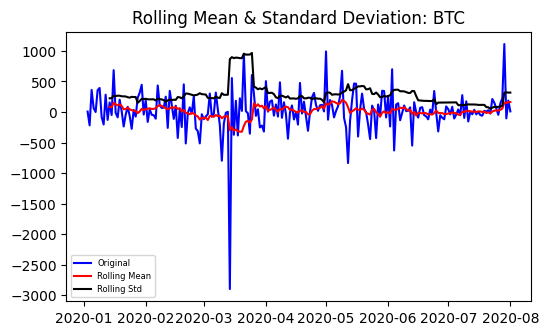

Open
ADF Statistic: -9.745533713549797
p-value: 8.275393870677802e-17
Critical Values:
	1%: -3.461878735881654
	5%: -2.875403665910809
	10%: -2.574159410430839


In [11]:
btc.df_log_shift()
plt.show()

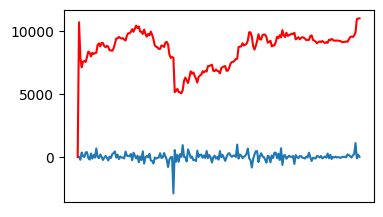

In [12]:
btc.arima_build(2,2,2)

ValueError: Excel file format cannot be determined, you must specify an engine manually.

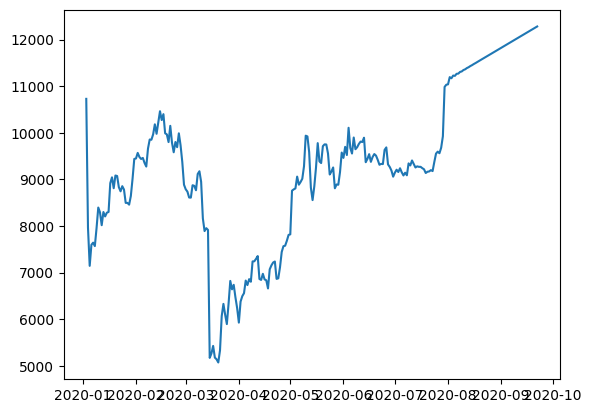

In [13]:
btc.arima_predict()

In [ ]:
alp=0.05
col='Open'

date_min=pd.to_datetime("2020.01.01")
date_max=pd.to_datetime("2020.06.01")
date_test=pd.to_datetime("2020.07.01")

doge=CurrencyAnalysis(alp,df_doge,col,date_min,date_max,date_test,'Dogecoin')
#Doge isn't in trend
# => d: number of nonseasonal differences (differencing order) = 1
# p: number of autoregressive terms (AR order)
    
doge.arima_build(1,1,3)
plt.clf()
doge.arima_predict(174)